# A Linear Programming Model for Optimal Transport 

<div class="alert alert-block alert-success">
$\newcommand{\R}{\mathbb{R}} \newcommand{\Z}{\mathbb{Z}} \newcommand{\N}{\mathbb{N}} 
\newcommand{\bff}{\mathbf{f}} \newcommand{\bx}{\mathbf{x}} 
\newcommand{\by}{\mathbf{y}} \newcommand{\bo}{\mathbb{1}} \newcommand{\bJ}{\mathbf{J}}$
In this notebook, we will aim to solve the following optimal transport problem in its linear form:
\begin{align}
\min c^\top x,
\end{align}
subject to
\begin{align}
    \begin{pmatrix} \mathbb{1}_N^\top \otimes I_M \\ I_N \otimes \mathbb{1}_M^\top \end{pmatrix} x &= 
    \begin{pmatrix} m \\ n \end{pmatrix},
    \\
    x &\geq 0;
\end{align}
where $x\in \R^{M\times N}$, $m \in \R^M$, $n \in \R^N$, and $c \in \R^{M\times N}$ is a positive cost vector.
</div>

<div class="alert alert-block alert-info">
The following packages are loaded into the environment. 
</div>

In [1]:
from gurobipy import *
import numpy as np
from numpy         import asarray, indices, double, allclose
from pandas        import read_csv
from skimage.io    import imread, imshow
from scipy.spatial import distance_matrix
from scipy.spatial.distance import cdist

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

<div class="alert alert-block alert-success">
We can actually solve the original problem with an LP solver that allows indexing:
\begin{align}
    \min c : \gamma,
\end{align}
subject to
\begin{align}
    \sum_{j} \gamma_{i,j} &= m_i
    \\
    \sum_{i} \gamma_{i,j} &= n_j
    \\
    \gamma_{i,j} &\geq 0.
\end{align}
</div>

<div class="alert alert-block alert-info">
Here we define the following basic objects:
    
1. `M` and `N` are the number of points where the measures of `μ` and `ν` are concentrated,
2. `c` is the vector of costs.
</div>

In [2]:
# File names
nomᵤ = 'data32_1001.csv'
nomᵥ = 'data32_1002.csv'

In [3]:
μ = read_csv(nomᵤ).values.astype(double);    μ /= μ.max()
ν = read_csv(nomᵥ).values.astype(double);    ν /= ν.max()

In [4]:
M = μ.size
N = ν.size

In [5]:
# Coordinates:
Iₘ = (indices(μ.shape)/(asarray(μ.shape)-1)[::,np.newaxis,np.newaxis]).reshape(2,M).T
Iₙ = (indices(ν.shape)/(asarray(ν.shape)-1)[::,np.newaxis,np.newaxis]).reshape(2,N).T
#Sparse alternatives:    indices(μ.shape, sparse=True)      &      indices(ν.shape, sparse=True)

In [6]:
# Cost matrix:
c = cdist(Iₘ, Iₙ, 'sqeuclidean')        # Alternative: distance_matrix(Iₘ, Iₙ) ** 2

In [7]:
m = μ.ravel() / μ.sum()
n = ν.ravel() / ν.sum()

<div class="alert alert-block alert-warning">
Optimisation model
</div>

In [8]:
# Model
mo = Model()
γ  = {}
γ = mo.addMVar( (M,N), vtype = 'C', name ='g', obj = c, lb = 0.0)

mo.addConstrs( (γ[i,:].sum() == m[i] for i in range(M)), name='m' );
mo.addConstrs( (γ[:,j].sum() == n[j] for j in range(N)), name='n');

Academic license - for non-commercial use only - expires 2021-07-17
Using license file /Users/andy/gurobi.lic


In [9]:
mo.setParam('Method', 0);    mo.Params.Presolve = 0;    mo.optimize()
#?mo.Params.Method

Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter Presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1984 rows, 984064 columns and 1968128 nonzeros
Model fingerprint: 0x0603826e
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-03, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-04, 8e-03]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5973186e+00   9.988030e-01   9.820830e+11      0s
   81601    1.1831609e-02   0.000000e+00   0.000000e+00      1s

Solved in 81601 iterations and 1.11 seconds
Optimal objective  1.183160853e-02


In [10]:
# Solve with barrier
mo.reset();    mo.setParam('Method', 2);    mo.optimize()

Discarded solution information
Changed value of parameter Method to 2
   Prev: 0  Min: -1  Max: 5  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1984 rows, 984064 columns and 1968128 nonzeros
Model fingerprint: 0x0603826e
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-03, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-04, 8e-03]
Ordering time: 0.01s

Barrier statistics:
 AA' NZ     : 9.841e+05
 Factor NZ  : 1.969e+06 (roughly 400 MBytes of memory)
 Factor Ops : 2.605e+09 (less than 1 second per iteration)
 Threads    : 8

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.49539779e+04  0.00000000e+00  9.92e+01 0.00e+00  1.68e-01     1s
   1   2.86197676e+03 -5.49082320e-01  9.07e+00 1.33e-15  1.55e-02     1s
   2   1.00409861e+00 -5.487

<div class="alert alert-block alert-warning">
Output
</div>

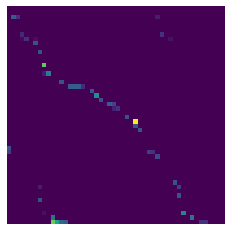

In [11]:
plt.imshow(γ.x[:50,:50]);  plt.axis('off');  plt.show()

In [12]:
print(γ.x)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.00064002 0.00030815 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.000557  ]]


Now we check that the conditional densities coincide:

In [13]:
allclose(γ.x.sum(0), n), allclose(γ.x.sum(1), m)

(True, True)

We can then export our inputs and outputs for comparison:

In [14]:
np.save(nomᵤ[:-4] + '-' + nomᵥ[:-4] + '_Cost',   c)    # Cost matrix c
np.save(nomᵤ[:-4] + '-' + nomᵥ[:-4] + '_m'   ,   m)    # Source measure m
np.save(nomᵤ[:-4] + '-' + nomᵥ[:-4] + '_n'   ,   n)    # Target measure m
np.save(nomᵤ[:-4] + '-' + nomᵥ[:-4] + '_Sol' , γ.x)    # Source measure m

---